# 第8章 DQN改进算法

In [20]:
import random
import gym
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import rl_utils
from tqdm import tqdm


class Qnet(torch.nn.Module):
    ''' 只有一层隐藏层的Q网络 '''
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(Qnet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [21]:
class DQN:
    ''' DQN算法实现，支持Vanilla DQN 和 Double DQN 模式 '''

    def __init__(self,
                 state_dim,       # 状态空间维度
                 hidden_dim,      # 隐藏层维度
                 action_dim,      # 动作空间维度（离散）
                 learning_rate,   # 学习率
                 gamma,           # 折扣因子
                 epsilon,         # ε-贪婪策略中的随机因子
                 target_update,   # 目标网络更新频率
                 device,          # 运算设备（CPU/GPU）
                 dqn_type='VanillaDQN'  # 算法类型，可选：VanillaDQN 或 DoubleDQN
                 ):
        self.action_dim = action_dim
        self.device = device
        self.dqn_type = dqn_type
        self.gamma = gamma
        self.epsilon = epsilon
        self.target_update = target_update
        self.count = 0  # 记录更新次数，用于目标网络同步控制

        # 初始化主网络和目标网络（结构一致）
        self.q_net = Qnet(state_dim, hidden_dim, action_dim).to(device)
        self.target_q_net = Qnet(state_dim, hidden_dim, action_dim).to(device)

        # 使用 Adam 优化器训练主网络
        self.optimizer = torch.optim.Adam(self.q_net.parameters(), lr=learning_rate)

    def take_action(self, state):
        '''根据当前策略选择动作，采用 ε-贪婪策略'''
        if np.random.random() < self.epsilon:
            # 探索：随机选择动作
            return np.random.randint(self.action_dim)
        else:
            # 利用：选择最大 Q 值对应的动作
            '''
            	原始状态值（无 batch）     .unsqueeze(0) 后（有 batch）
                [0.1, 0.2, 0.3]     →    [[0.1, 0.2, 0.3]]
                shape: (3,)         →       shape: (1, 3)
            '''
            state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(self.device)  # 加 batch 维
            return self.q_net(state).argmax().item() # 求的是当前状态下，具有最大 Q 值的动作编号（action index）

    def max_q_value(self, state):
        '''计算当前状态下的最大Q值（用于可视化）'''
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(self.device)
        return self.q_net(state).max().item()

    def update(self, transition_dict):
        '''用经验回放中的样本更新 Q 网络参数'''
        # 从经验字典中提取张量
        states = torch.tensor(transition_dict['states'], dtype=torch.float32).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float32).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float32).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float32).view(-1, 1).to(self.device)

        # 当前 Q 网络对当前状态动作的评估值
        # gather(1, actions) 是在二维张量的第1维（列方向）上，按照 actions 中给出的索引提取元素，
        # 常用于 DQN 中从 Q(s, ·) 中提取实际采取的动作 a 对应的 Q 值：Q(s, a)。
        q_values = self.q_net(states).gather(1, actions)

        # 计算下一个状态的最大 Q 值，核心不同之处
        '''
        Double DQN 将动作选择（argmax）交给主网络 q_net，动作价值评估交给目标网络 target_q_net，
        而 Vanilla DQN 的动作选择和评估都由目标网络完成，容易产生 Q 值过估计（overestimation）。
        '''
        if self.dqn_type == 'DoubleDQN':
            # Double DQN：主网络选动作，目标网络评估价值，避免 Q 值过估计
            max_action = self.q_net(next_states).argmax(dim=1, keepdim=True)
            max_next_q_values = self.target_q_net(next_states).gather(1, max_action)
        else:
            # Vanilla DQN：目标网络直接取最大 Q 值
            max_next_q_values = self.target_q_net(next_states).max(1)[0].view(-1, 1)

        # 构建 TD 目标值
        q_targets = rewards + self.gamma * max_next_q_values * (1 - dones)

        # 计算均方误差损失
        loss = F.mse_loss(q_values, q_targets)

        # 反向传播优化
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # 定期将主网络参数同步给目标网络，无论是 Vanilla DQN 还是 Double DQN，它们都必须使用滞后的 target 网络。
        # 这是 DQN 系列的基本结构要求
        if self.count % self.target_update == 0:
            self.target_q_net.load_state_dict(self.q_net.state_dict())
        self.count += 1

In [22]:
# 超参数设置
lr = 1e-2                     # 学习率（注意对 Pendulum 来说可能偏大，可调为 1e-3 试试）
num_episodes = 200           # 训练轮数
hidden_dim = 128             # Q 网络的隐藏层维度
gamma = 0.98                 # 折扣因子（未来奖励的衰减程度）
epsilon = 0.01               # ε-贪婪策略中的随机探索概率（探索率）
target_update = 50          # 每训练多少次更新一次目标网络
buffer_size = 5000          # 经验回放池容量
minimal_size = 1000         # 经验池中最少样本数，达到才开始训练
batch_size = 64             # 每次训练采样的 batch 大小

# 自动选择设备：优先使用GPU
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# 环境初始化
env_name = 'Pendulum-v1'     # 使用 Gym 中的连续动作环境 Pendulum
env = gym.make(env_name)     # 创建环境实例
state_dim = env.observation_space.shape[0]  # 状态空间维度（通常为3）
action_dim = 11              # 将连续动作 [-2, 2] 区间划分为 11 个离散动作，用于 DQN 处理

# 将离散动作编号映射回连续动作值（用于兼容 DQN 在连续动作环境中使用）
def dis_to_con(discrete_action, env, action_dim):
    """
    参数：
        discrete_action: int，离散动作编号（范围：0 ~ action_dim-1）
        env: 当前 Gym 环境对象（用于获取动作上下界）
        action_dim: int，总共划分的离散动作数量

    返回：
        连续动作值：float，映射到 env.action_space.low ~ env.action_space.high 之间
    """
    action_lowbound = env.action_space.low[0]    # 连续动作的最小值（如 -2.0）
    action_upbound = env.action_space.high[0]    # 连续动作的最大值（如 +2.0）
    
    # 线性映射：离散动作索引 → 连续动作值
    return action_lowbound + (discrete_action / (action_dim - 1)) * (action_upbound - action_lowbound)

In [23]:
def train_DQN(agent, env, num_episodes, replay_buffer, minimal_size, batch_size):
    """
    使用 DQN 训练智能体 agent 与环境 env 交互

    参数：
        agent: DQN 智能体对象，包含 q_net、策略与更新逻辑
        env: gym 环境对象
        num_episodes: 总训练轮数
        replay_buffer: 经验回放池对象
        minimal_size: 启动训练所需的最小样本数
        batch_size: 每次采样用于训练的 batch 大小

    返回：
        return_list: 每轮 episode 的累积奖励记录
        max_q_value_list: 每步的最大 Q 值记录（用于可视化监控训练稳定性）
    """
    return_list = []         # 记录每轮 episode 的累积回报
    max_q_value_list = []    # 记录每步的最大 Q 值（用于分析学习过程）
    max_q_value = 0          # 初始 Q 值参考（用于平滑）

    # 将总训练分成10段，便于观察 tqdm 进度条
    for i in range(10):
        with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
            for i_episode in range(int(num_episodes / 10)):
                episode_return = 0

                # ✅ 初始化状态（兼容新旧 Gym API）
                try:
                    state, _ = env.reset()
                except:
                    state = env.reset()
                done = False

                # ✅ 与环境交互，直至 episode 结束
                while not done:
                    # 根据策略选动作（ε-贪婪策略）
                    action = agent.take_action(state)

                    # 记录最大 Q 值（用于可视化学习过程的稳定性）
                    max_q_value = agent.max_q_value(state) * 0.005 + max_q_value * 0.995
                    max_q_value_list.append(max_q_value)

                    # 将离散动作编号转换为连续动作值（适用于 Pendulum-v1 等环境）
                    action_continuous = dis_to_con(action, env, agent.action_dim)

                    # 环境执行动作，返回新状态与奖励
                    next_state, reward, terminated, truncated, _ = env.step([action_continuous])
                    done = terminated or truncated

                    # 存储 transition 到经验回放池
                    replay_buffer.add(state, action, reward, next_state, done)

                    # 更新状态与累计奖励
                    state = next_state
                    episode_return += reward

                    # ✅ 条件满足后开始训练
                    if replay_buffer.size() > minimal_size:
                        b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
                        transition_dict = {
                            'states': b_s,
                            'actions': b_a,
                            'next_states': b_ns,
                            'rewards': b_r,
                            'dones': b_d
                        }
                        agent.update(transition_dict)

                # 当前 episode 完成，记录累计回报
                return_list.append(episode_return)

                # 每10轮打印一次最近10次平均回报
                if (i_episode + 1) % 10 == 0:
                    pbar.set_postfix({
                        'episode': '%d' % (num_episodes / 10 * i + i_episode + 1),
                        'return': '%.3f' % np.mean(return_list[-10:])
                    })
                pbar.update(1)

    return return_list, max_q_value_list

Iteration 9: 100%|██████████| 20/20 [00:01<00:00, 10.52it/s, episode=200, return=-204.788]


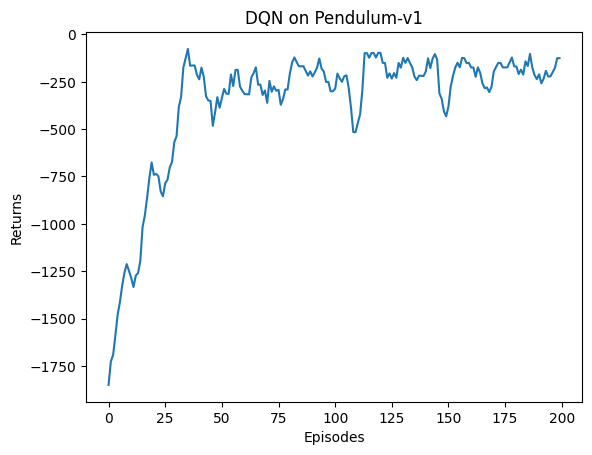

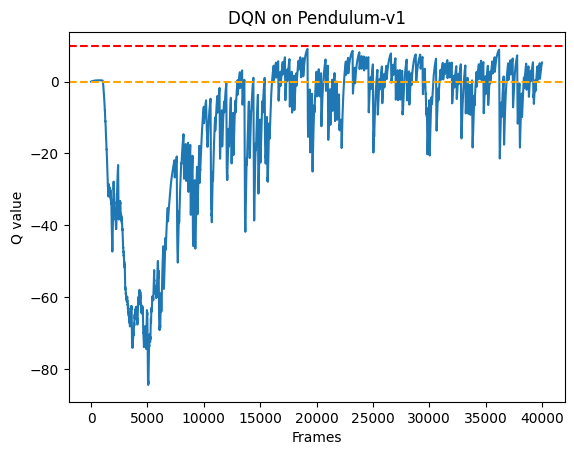

In [ ]:
# 设置随机种子，确保实验可复现（包括 Python、NumPy、PyTorch、Gym）
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

# 初始化 Gym 环境时设置种子（兼容 Gym 0.26+ 新 API）
env.reset(seed=0)
env.action_space.seed(0)           # 控制 env.action_space.sample() 的稳定性
env.observation_space.seed(0)      # 控制 env.observation_space.sample() 的稳定性

# 创建经验回放池
replay_buffer = rl_utils.ReplayBuffer(buffer_size)

# 初始化 DQN 智能体
agent = DQN(state_dim, hidden_dim, action_dim,
            lr, gamma, epsilon, target_update, device)

# 启动训练：记录每轮回报 + 每步最大Q值
return_list, max_q_value_list = train_DQN(agent, env, num_episodes,
                                          replay_buffer, minimal_size,
                                          batch_size)

episodes_list = list(range(len(return_list)))
mv_return = rl_utils.moving_average(return_list, 5)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on {}'.format(env_name))
plt.show()

frames_list = list(range(len(max_q_value_list)))
plt.plot(frames_list, max_q_value_list)
plt.axhline(0, c='orange', ls='--')
plt.axhline(10, c='red', ls='--')
plt.xlabel('Frames')
plt.ylabel('Q value')
plt.title('DQN on {}'.format(env_name))
plt.show()

Iteration 9: 100%|██████████| 20/20 [00:01<00:00, 13.02it/s, episode=200, return=-320.018]


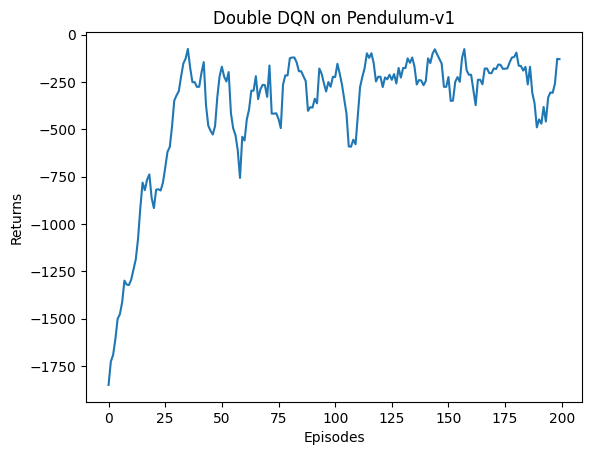

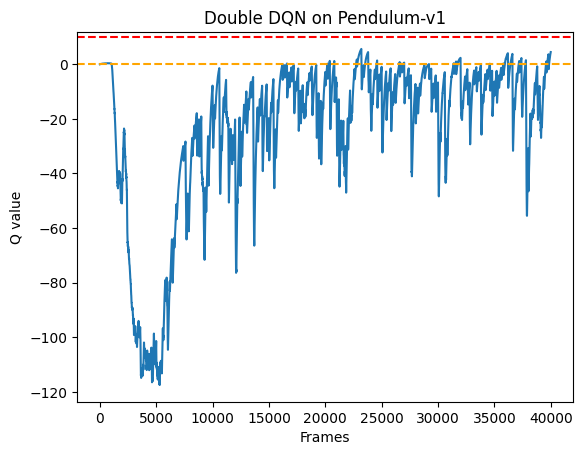

In [25]:
random.seed(0)
np.random.seed(0)

env.reset(seed=0)
env.action_space.seed(0)
env.observation_space.seed(0)

torch.manual_seed(0)
replay_buffer = rl_utils.ReplayBuffer(buffer_size)
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon,
            target_update, device, 'DoubleDQN')
return_list, max_q_value_list = train_DQN(agent, env, num_episodes,
                                          replay_buffer, minimal_size,
                                          batch_size)

episodes_list = list(range(len(return_list)))
mv_return = rl_utils.moving_average(return_list, 5)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Double DQN on {}'.format(env_name))
plt.show()

frames_list = list(range(len(max_q_value_list)))
plt.plot(frames_list, max_q_value_list)
plt.axhline(0, c='orange', ls='--')
plt.axhline(10, c='red', ls='--')
plt.xlabel('Frames')
plt.ylabel('Q value')
plt.title('Double DQN on {}'.format(env_name))
plt.show()

✅ 1. Vanilla DQN 通常更早出现高估误差，波动较小但不稳定  
	•	容易出现“Q 值过高 → 策略过激 → reward 极差”的现象  
	•	如第一组在 iteration 3~6 之间突然从 -249 降到 -321，再跳到 -212，有明显 Q 值爆冲回退的特征  
 
✅ 2. Double DQN 收敛更慢，但稳定性更高  
	•	虽然中间 -428 一次偏低，但整体波动在收敛阶段更窄（-180~-320 区间）  
	•	Double DQN 通常表现为 learning speed 略慢，长期更稳、Q 值不爆炸  


    Vanilla DQN 在 early stage 更快靠近较好策略，但因 overestimation 会导致不稳定或“提前收敛到 sub-optimal 策略”；Double DQN 减少了   overestimation，往往“走得慢但走得远”。

Iteration 9: 100%|██████████| 20/20 [00:03<00:00,  6.61it/s, episode=200, return=-163.345]


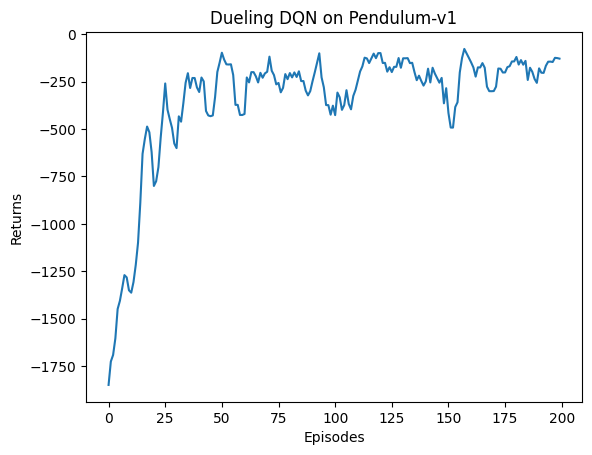

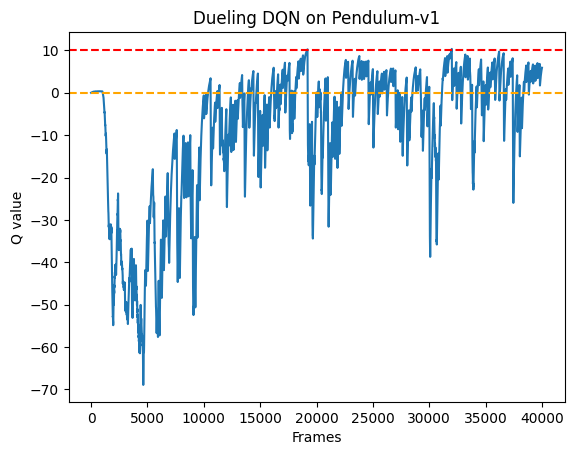

In [26]:
class VAnet(torch.nn.Module):
    ''' Dueling DQN 网络结构：包含共享层、A 网络和 V 网络 '''
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(VAnet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)  # 共享特征提取层
        self.fc_A = torch.nn.Linear(hidden_dim, action_dim)  # Advantage 分支
        self.fc_V = torch.nn.Linear(hidden_dim, 1)           # Value 分支

    def forward(self, x):
        A = self.fc_A(F.relu(self.fc1(x)))                   # 计算 A(s, a)
        V = self.fc_V(F.relu(self.fc1(x)))                   # 计算 V(s)
        Q = V + A - A.mean(1, keepdim=True)                  # 聚合为 Q(s, a)
        return Q


class DQN:
    ''' DQN算法,包括Double DQN和Dueling DQN '''
    def __init__(self,
                 state_dim,
                 hidden_dim,
                 action_dim,
                 learning_rate,
                 gamma,
                 epsilon,
                 target_update,
                 device,
                 dqn_type='VanillaDQN'):
        self.action_dim = action_dim

        if dqn_type == 'DuelingDQN':  # ✅ 若启用 Dueling DQN，则使用带有 V/A 分支的结构
            # Q(s, a) = V(s) + A(s, a) - mean(A(s, ·))，将状态价值和优势分支分离建模
            self.q_net = VAnet(state_dim, hidden_dim, self.action_dim).to(device)
            self.target_q_net = VAnet(state_dim, hidden_dim, self.action_dim).to(device)
        else:
            # 若使用 Vanilla DQN 或 Double DQN，则使用标准 Q 网络结构（单一 Q(s, a) 输出）
            self.q_net = Qnet(state_dim, hidden_dim, self.action_dim).to(device)
            self.target_q_net = Qnet(state_dim, hidden_dim, self.action_dim).to(device)
            
        self.optimizer = torch.optim.Adam(self.q_net.parameters(),
                                          lr=learning_rate)
        self.gamma = gamma
        self.epsilon = epsilon
        self.target_update = target_update
        self.count = 0
        self.dqn_type = dqn_type
        self.device = device

    def take_action(self, state):
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.action_dim)
        else:
            state = torch.tensor([state], dtype=torch.float).to(self.device)
            action = self.q_net(state).argmax().item()
        return action

    def max_q_value(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        return self.q_net(state).max().item()

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(
            self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)

        q_values = self.q_net(states).gather(1, actions)
        if self.dqn_type == 'DoubleDQN':
            max_action = self.q_net(next_states).max(1)[1].view(-1, 1)
            max_next_q_values = self.target_q_net(next_states).gather(
                1, max_action)
        else:
            max_next_q_values = self.target_q_net(next_states).max(1)[0].view(
                -1, 1)
        q_targets = rewards + self.gamma * max_next_q_values * (1 - dones)
        dqn_loss = torch.mean(F.mse_loss(q_values, q_targets))
        self.optimizer.zero_grad()
        dqn_loss.backward()
        self.optimizer.step()

        if self.count % self.target_update == 0:
            self.target_q_net.load_state_dict(self.q_net.state_dict())
        self.count += 1


random.seed(0)
np.random.seed(0)

env.reset(seed=0)
env.action_space.seed(0)
env.observation_space.seed(0)

torch.manual_seed(0)
'''
Dueling DQN 在结构上引入了两个分支：一个估计状态价值 V(s)，一个估计动作优势 A(s, a)，它们共同生成最终的 Q(s, a) 值；
但在训练过程中，仍然像普通 DQN 一样只优化输出的 Q 值，不单独优化 V 或 A，
整体训练逻辑、损失函数和更新方式保持不变，仅通过更强的结构表达提升学习效率和稳定性。
'''
replay_buffer = rl_utils.ReplayBuffer(buffer_size)
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon,
            target_update, device, 'DuelingDQN')
return_list, max_q_value_list = train_DQN(agent, env, num_episodes,
                                          replay_buffer, minimal_size,
                                          batch_size)

episodes_list = list(range(len(return_list)))
mv_return = rl_utils.moving_average(return_list, 5)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Dueling DQN on {}'.format(env_name))
plt.show()

frames_list = list(range(len(max_q_value_list)))
plt.plot(frames_list, max_q_value_list)
plt.axhline(0, c='orange', ls='--')
plt.axhline(10, c='red', ls='--')
plt.xlabel('Frames')
plt.ylabel('Q value')
plt.title('Dueling DQN on {}'.format(env_name))
plt.show()